<a href="https://colab.research.google.com/github/viraatdas/Purdue_CompVis_Workshop/blob/12_end_predict/speed_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
print("wus good")

wus good


Import video files

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Import libraries

In [0]:
import os
import csv
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Organize file paths

In [0]:
train_video = "./drive/My Drive/speed_predict/train.mp4"
labels = "./drive/My Drive/speed_predict/train.txt"
OUTPUT_PATH = "./drive/My Drive/speed_predict/data_preprocessed/"
FRAME_RATE = 20

if not os.path.exists(OUTPUT_PATH):
  os.mkdir(OUTPUT_PATH)
  print(f"Directory {OUTPUT_PATH} created")

PreProcessor Class

In [0]:
class PreProcessor():
  def __str__(self):
    # indicate class description
    return "Pre-processor class"
  def grayscale(self, frame):
    # converts frame to gray scale
    return cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  
  def plot_training_speed(self, data):
    # plot labels
    data = np.loadtxt(data)
    plt.plot(data)
    plt.show()
  def generate_images(self, file_path, label_path, gray=False):
    # Takes the video file and generates images for each
    # of it's frames. The time for each frame and the image path
    # for the corresponding frame is stored in a csv

    # Load the speeds
    speeds = np.loadtxt(label_path)

    # Video file
    video_capture = cv2.VideoCapture(file_path)

    # Check if number of labels is the same as number of frame
    if len(speeds) == video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
      print("Labels are equal to number of frames")
    else:
      print("Check if labels are equal to number of frames")
      return
    
    with open("processed.csv", "w+") as file:
      writer = csv.writer(file)
      time_between_frames = 1 / FRAME_RATE
      time_elapsed = 0

      for idx, i in enumerate(speeds):
        ret, frame = video_capture.read()
        time_elapsed += time_between_frames
        if gray == True:
          frame = self.grayscale(frame)
        if ret:
          # cv2_imshow(frame)
          image_path = OUTPUT_PATH + str(time_elapsed) + '.jpg'
          cv2.imwrite(image_path, frame)
          writer.writerow([image_path, time_elapsed, speeds[idx]])
        if cv2.waitKey(1) & 0xFF == ord('q'):
          break
      video_capture.release()
      cv2.destroyAllWindows()

  def shuffle_frame_pairs(self, dataframe, val_split=1):
    """Method that shuffles pairs of frames from the video.
    Takes a dataframe as an argument, and returns a training
    and validation dataframe. A custom method like this rather
    than a traditional test, train split is used, as we need
    pair of frames, later on to do optical flow"""
    training_data = pd.DataFrame()
    validation_data = pd.DataFrame()
    df_len = dataframe.shape[0]
    for i in range(df_len - 1):
        idx1 = np.random.randint(df_len - 1)
        idx2 = idx1 + 1
        row1 = dataframe.iloc[[idx1]].reset_index()
        row2 = dataframe.iloc[[idx2]].reset_index()
        randInt = np.random.randint(9)
        if 0 <= randInt <= val_split:
            valid_frames = [validation_data, row1, row2]
            validation_data = pd.concat(
                valid_frames, axis=0, join='outer', ignore_index=False)
        if randInt >= val_split + 1:
            train_frames = [training_data, row1, row2]
            training_data = pd.concat(
                train_frames, axis=0, join='outer', ignore_index=False)

    return training_data, validation_data

  def adjust_brightness(self, image, factor, slice):
    # Convert to hue, saturation, value model
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    hsv[:, :, slice] = hsv[:, :, slice] * factor
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

  def crop_sky_and_dashboard(self, frame):
      frame = frame[100:440, :-90]
      image = cv2.resize(frame, (220, 66), interpolation=cv2.INTER_AREA)
      return image

  def optical_flow(self, im_c, im_n):
      gray_c = self.grayscale(im_c)
      gray_n = self.grayscale(im_n)
      hsv = np.zeros_like(im_c)
      hsv[:, :, 1] = cv2.cvtColor(im_n, cv2.COLOR_RGB2HSV)[:, :, 1]


      flow = cv2.calcOpticalFlowFarneback(gray_c, gray_n,
                                          flow_mat,
                                          image_scale,
                                          nb_images,
                                          win_size,
                                          nb_iterations,
                                          deg_expansion,
                                          STD,
                                          0)

      mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
      hsv[:, :, 0] = ang * (180 / np.pi / 2)
      hsv[:, :, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
      hsv = np.asarray(hsv, dtype=np.float32)
      rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
      #cv2.imwrite("./flow.jpg", rgb_flow)

      return rgb_flow


  def preprocess_image_valid_from_path(self, image_path, speed):
      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = self.adjust_brightness(img, 0.2, 2)    
      img = self.crop_sky_and_dashboard(img)
      return img, speed


  def preprocess_image_from_path(self, image_path, speed):
      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = self.adjust_brightness(img, 0.2, 2)    
      img = self.crop_sky_and_dashboard(img)
      return img, speed

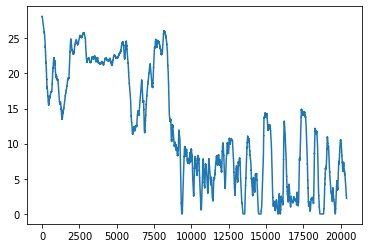

Labels are equal to number of frames


KeyboardInterrupt: ignored

In [44]:
pre = PreProcessor()
pre.plot_training_speed(labels)
pre.generate_images(train_video, labels)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
import numpy as np
import pandas as pd

In [0]:
# Model

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, ELU, TimeDistributed, Flatten, Dropout, Lambda
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import MaxPooling2D

IMG_SHAPE = (66, 220, 3)


def speed_model():
    inputs = Input(shape=IMG_SHAPE)
    inputs1 = Lambda(lambda x: x/ 127.5 - 1, input_shape = IMG_SHAPE)(inputs)

    conv1 = Conv2D(24, (5, 5), padding="valid")(inputs1)
    act1 = Activation(ELU())(conv1)
    conv2 = Conv2D(36, (5, 5), strides=(2, 2), padding="valid")(act1)
    act2 = Activation(ELU())(conv2)
    drop1 = Dropout(0.5)(act2)
    conv3 = Conv2D(48, (5, 5), strides=(2, 2), padding="valid")(drop1)
    act3 = Activation(ELU())(conv3)
    conv4 = Conv2D(64, (3, 3), strides=(1, 1), padding="valid")(act3)
    act4 = Activation(ELU())(conv4)
    conv5 = Conv2D(64, (3, 3), padding="valid")(act4)


    flat1 = Flatten()(conv5)
    act4 = Activation(ELU())(flat1)
    dense1 = Dense(100)(act4)
    act5 = Activation(ELU())(dense1)
    dense2 = Dense(50)(act5)
    act6 = Activation(ELU())(dense2)
    dense4 = Dense(10)(act6)
    act8 = Activation(ELU())(dense4)
    output = Dense(1)(act8)

    model = Model(inputs, output)
    adam = Nadam()
    model.compile(optimizer=adam, loss='mse')

    print(model.summary())
    return model

In [0]:
# training functions
def generate_training_data(data, batch_size = 16):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            idx = np.random.randint(1, len(data) - 1)
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            time_now = row_now[1].values[0]
            time_prev = row_prev[1].values[0]
            time_next = row_next[1].values[0]
            
            if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
                row1 = row_prev
                row2 = row_now
                
            elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
                row1 = row_now
                row2 = row_next
                
            x1, y1 = pre.preprocess_image_from_path(row1[0].values[0],row1[2].values[0]) 
            x2, y2 = pre.preprocess_image_from_path(row2[0].values[0],row2[2].values[0])
           
            img_diff = pre.optical_flow(x1, x2)
            y = np.mean([y1, y2])
            
            image_batch[i] = img_diff
            label_batch[i] = y
            
        yield shuffle(image_batch, label_batch)


def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): 
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            time_now = row_now[1].values[0]
            time_prev = row_prev[1].values[0]
            time_next = row_next[1].values[0]
            
            if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58:
                row1 = row_prev
                row2 = row_now
                
            elif time_next - time_now > 0 and 0.000001 < time_next - time_now < 0.58:
                row1 = row_now
                row2 = row_next

            x1, y1 = pre.preprocess_image_valid_from_path(row1[0].values[0], row1[2].values[0])
            x2, y2 = pre.preprocess_image_valid_from_path(row2[0].values[0], row2[2].values[0])
            
            img_diff = pre.optical_flow(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            yield img_diff, speed

In [0]:
flow_mat = None
image_scale = 0.5
nb_images = 1
win_size = 15
nb_iterations = 2
deg_expansion = 5
STD = 1.3

In [29]:
# training the model

filepath = 'model-weights.h5'
df = pd.read_csv("./processed.csv", header = None)
pre = PreProcessor()
train, test = pre.shuffle_frame_pairs(df)
size_test = len(test.index)
size_train = len(train.index)
#print(size_test)
#print(size_train)
dl_model = speed_model()
earlyStopping = EarlyStopping(monitor='val_loss', 
                          patience=2, 
                          verbose=1, 
                          min_delta = 0.23,
                          mode='min',)
modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)
callbacks_list = [modelCheckpoint, earlyStopping]
train_generator = generate_training_data(train)
test_generator = generate_validation_data(test)
history = dl_model.fit_generator(
        train_generator, 
        steps_per_epoch = 555,
        epochs = 25,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = test_generator,
        validation_steps = size_test)

print(history)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 66, 220, 3)]      0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 220, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 216, 24)       1824      
_________________________________________________________________
activation_8 (Activation)    (None, 62, 216, 24)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 106, 36)       21636     
_________________________________________________________________
activation_9 (Activation)    (None, 29, 106, 36)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 106, 36)       0   

KeyboardInterrupt: ignored

In [0]:
# Removing all jpg images from folder

# import os
# for file in os.listdir(os.getcwd()): 
#   if file.endswith('.jpg'):
#     os.remove(file) 


In [0]:
os.getcwd()

In [0]:
# predict
from tensorflow.keras.models import load_model
import pickle
import numpy as np
import pandas as pd

pre = PreProcessor()

def predictions(data, model):
    new_data = [] 
    for idx in range(1, len(data.index)-1):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now[1].values[0]
        time_prev = row_prev[1].values[0]
        time_next = row_next[1].values[0]
        
        if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
            row1 = row_prev
            row2 = row_now
            
        elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
            row1 = row_now
            row2 = row_next
            
        x1, y1 = pre.preprocess_image_from_path(row1[0].values[0],row1[2].values[0]) 
        x2, y2 = pre.preprocess_image_from_path(row2[0].values[0],row2[2].values[0])
       
        img_diff = pre.optical_flow(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])
        
        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        new_data.append([prediction[0][0], y2, error[0][0], time_now, time_prev])
    return pd.DataFrame(new_data)


def get_pred_mse(preds):
    df = pd.read_pickle(preds)
    avg = np.mean(df[2].values**2)
    return avg





In [43]:
print(os.getcwd())
model = speed_model()

model.load_weights("./drive/My Drive/speed_predict/model-weights.h5")

df = pd.read_csv("./drive/My Drive/speed_predict/processed.csv", header = None)
pre = PreProcessor()
train, test = pre.shuffle_frame_pairs(df)
test_generator = training.generate_validation_data(test)
val_score = model.evaluate_generator(test_generator, steps=len(test))
data = predictions(test, model)
data.to_pickle("./predictions.pkl")

print(get_pred_mse("predictions.pkl"))

/content
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 66, 220, 3)]      0         
_________________________________________________________________
lambda_11 (Lambda)           (None, 66, 220, 3)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 62, 216, 24)       1824      
_________________________________________________________________
activation_88 (Activation)   (None, 62, 216, 24)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 29, 106, 36)       21636     
_________________________________________________________________
activation_89 (Activation)   (None, 29, 106, 36)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 29, 106, 36) 

FileNotFoundError: ignored